# Bounded Fits to Convex Functions

_Edward Burnell_


Convex modeling languages such as JuMP, cvx, GPkit, and Convex.jl provide ways to create and solve complex descriptions of a convex optimization problem. The role of such a modeling language is to translate the user's intent and understanding of their problem into a form conducive to numerical solving, and this has proved an effective and popular abstraction. 

A common user intent is the creation of tradeoff curves between the optimal cost and some parameter of the model.
There are many reasons a user could want to make such a curve; parameters may represent unmodeled effects or other uncertainties, so the tradeoff curve will show the result's sensitivity to that uncertainty.
Alternately, the model may have multiple objectives, and the tradeoff curve directly represents a Pareto frontier.

Whatever the user's reasons for wanting a tradeoff curve,  [JuMP](https://jump.readthedocs.io/en/latest/probmod.html#modifying-variables), [cvx](http://cvxr.com/cvx/doc/quickstart.html#an-optimal-trade-off-curve), [GPkit](http://gpkit.readthedocs.io/en/latest/advancedcommands.html#sweeps),  and [Convex.jl](http://convexjl.readthedocs.io/en/latest/loop.html) all explicitly document how to step the parameter through a series of values in a `for` loop, and to varying extents have features to make doing so easier. In other words, they all turn the user's desire to know how the  optimal cost varies over an interval into a grid of individual solution points. 

In most cases the immediate use of these solution points will be a simple line plot that linearly interpolates between them, as shown in the slope discontinuities of this [this cvx example](http://cvxr.com/cvx/doc/_images/tradeoff.pdf). For conventionally convex optimization, these secants of the actual cost are a conservative upper bound, but for log-convex problems such as Geometric Programs they provide no such guarantee unless they are linearly interpolated on a log-log plot, which few users will do of their own accord.

Guessing what resolution of grid to use can be tricky for the user, whose goal is generally to capture the interesting features of the tradeoff. Each solve can take a considerable amount of time, but using too few solves renders the plot meaningless: a secant line across the bowl of a parabola made by solving on either side of it is clearly not a useful description of the curve.


## Let's do better

### Approach 1: Secant interpolation

With a bit of math, we can do better. The simplest way to improve on the grid-search is to make use of the fact that the secant line is an upper bound: that is, given the parameter boundaries $p_0 \lt p_1$ and associated costs $c_0,\ c_1$:

$$c(p) \leq \underset{[p_0, p_1]}{\mathrm{secant}}(p) = c_1\frac{p-p_0}{p_1 - p_0} + c_0\ \ \forall p \in [p_0, p_1]$$

As this is an affine function of $p$, we can find the point at which using this secant line as a fit causes the most error:

$$\begin{equation*}
\begin{aligned}
& \underset{p}{\text{maximize}}
& & \mathrm{secant}(p) - c(p) \\
& \text{subject to}
& & p_o \leq p \leq p_1 \\
& & & \text{(+ the original constraints)}
\end{aligned}
\end{equation*}$$

Solving this problem gives us $p^*$, $c(p^*)$ just as if we had decided to solve for $p^*$ in our initial grid, but also bounds our error, guaranteeing that:

$$\text{max fit error} = \underset{[p_0, p_1]}{\mathrm{secant}(p)} - c(p) \leq \underset{[p_0, p_1]}{\mathrm{secant}(p^*)} - c(p^*)$$

This technique can be recursed on the new intervals $[p_0, p^*]$ and $[p^*, p_1]$ until a user-specified fit error tolerance is reached. An interval that reaches that tolerance sooner can stop solving sooner, providing more resolution in the high-curvature regions of the underlying cost function and dealing trivally with the linear regions.

Compared to the grid-stepping method, this means the user can directly communicate their intent (a curve that captures features beyond a certain size), and the software can use fewer solves to deliver the same resolution.

### Approach 2: Secant-tangent bounding

Alternatively, we can combine the following three facts:
  1. convex solvers generally return the dual solution of the problem
  2. this dual solution communicates the derivative of the cost function with respect to each parameter.
  3. the tangent lines formed by these derivatives form a lower bound for the cost

to, given $p_0,\ p_1,\ c_0,\ c_1$ as above, and the derivatives $s_0,\ s_1$, fully bound possible costs on the interval $[p_0,\ p_1]$:

$$\mathrm{max}(c_0 + s_0(p - p_0), c_1 + s_1(p - p_1)) = \mathrm{max}(\underset{[p_0, p_1]}{\mathrm{tangents}}(p)) \leq c(p) \leq \underset{[p_0, p_1]}{\mathrm{secant}}(p)
\\ \forall p \in [p_0, p_1]$$

By approximating the curve between $p_0$ and $p_1$ as halfway between this upper and lower bound, we can use the derivative information to provide a fit with $\text{max fit error}$ less then or equal to half the largest gap between the upper and lower bounds.

To find $\text{max fit error}$ we can solve the linear program (in one dimension this is the point at which the tangent lines intersect, but that does not extend to higher dimensions):

$$\begin{equation*}
\begin{aligned}
& \underset{p}{\text{maximize}}
& & 0.5 (\mathrm{secant}(p) - \mathrm{tangent\_max}(p)) \\
& \text{subject to}
& & p_o \leq p \leq p_1 \\
& & & \mathrm{tangent\_max} \geq \mathrm{tangent}_0(p) \\
& & & \mathrm{tangent\_max} \geq \mathrm{tangent}_1(p)
\end{aligned}
\end{equation*}$$

If $\text{max fit error}$ is still too high, we can recurse on the intervals $[p_0, p^*]$ and $[p^*, p_1]$ as above.


### Summary of approaches

Approach 1 is easier to implement (as it does not require parsing the dual solution), and without the LP solve is lower overhead. However, approach 2 can provide an error estimate and improve the fit without requiring any additional solves.

In general I would expect approach 2 to require fewer solves for tight fits, but because approach 1 operates directly on fit error, not on bounded possibilities, I expect that it will perform better in some cases.


## Multidimensional case

Several things become more difficult in higher dimensions.

First, the interval on which the fit is conducted becomes a volume, or a simplex at minimum complexity. Recursing on this, and creating the data structure to store and return this data, becomes much more complicated.

Secondly, as mentioned above in the description of approach 2, the point at which all the gradient hyperplanes (N-dimensional derivative slopes) intersect is not necessarily in the projection of the spanned simplex ((N-dimensional interval). Someone better at linear algebra than I could probably still determine $p^*$ without an LP solve, but my efforts to do so were unsuccessful.

## So what's in the code?

The code below uses approach 2 and simplex-spanning trees to store the solution, and works in 1 and 2 dimensions, with numerical errors at high accuracy in the 2-dimensional case. It turned out to be much more difficult to properly retrieve the data than I expected!

In [1]:
import Convex
import ECOS

Convex.set_default_solver(ECOS.ECOSSolver(verbose=0))

ECOS.ECOSSolver(Any[(:verbose,0)])

In [2]:
import Base.contains

In [3]:
abstract SpanningTree

worst_abstol(t::SpanningTree)  = maximum(map(worst_abstol, t.trees))
estimator(t::SpanningTree)     = p -> estimate(t, p)
lower_bounder(t::SpanningTree) = p -> lower_bound(t, p)
upper_bounder(t::SpanningTree) = p -> upper_bound(t, p)

estimate(t::SpanningTree, p)    =  estimate(smallest_containing(t, p), p)
lower_bound(t::SpanningTree, p) =  lower_bound(smallest_containing(t, p), p)
upper_bound(t::SpanningTree, p) =  upper_bound(smallest_containing(t, p), p)

function smallest_containing(t::SpanningTree, p::Array{Float64, 1})
    for subtree in t.trees
        if contains(subtree, p)
            return smallest_containing(subtree, p)
        end
    end
    throw(DomainError())
end

function refine_to(t::SpanningTree, abstol::Float64)
    for i in 1:length(t.trees)
        t.trees[i] = refine_to(t.trees[i], abstol)
    end
    return t
end

refine_to (generic function with 1 method)

In [4]:
abstract AbstractSimplexSpanningTree <: SpanningTree

# function smallest_containing(t::AbstractSimplexSpanningTree, p::Vector)
#    check closest point on each boundary-line is between 0 and 1 (+eps?);
#    how will this do with coplanar?
#    only one (st) should not be:
#         at first, for debug, @assert contains(st, p)
#         return st.smallest_containing(point)
#         then, if that works just return the first
#   else:
#     throw(DomainError())
# end

In [5]:
abstract SpanningLeaf <: AbstractSimplexSpanningTree

immutable SimplexSpanningTree <: AbstractSimplexSpanningTree
    corners::Array{Float64, 2}
    costs::Array{Float64, 1}
    trees::Array{SpanningTree, 1}
end

type SimplexSpanningCanopy <: AbstractSimplexSpanningTree
    corners::Array{Float64, 2}
    costs::Array{Float64, 1}
    grads::Array{Float64, 2}
    root::SpanningTree
    trees::Array{SpanningLeaf, 1}
    split_point::Array{Float64, 1}
    split_lb::Float64
    split_ub::Float64
    coplanar_idxs::Array{Int8, 1}
    
    function SimplexSpanningCanopy(corners, costs, grads, root)
        split, lb, ub, coplanar_idxs = find_split(corners, costs, grads)
        obj = new(corners, costs, grads, root, [], split, lb, ub, coplanar_idxs)
        idxs = filter(c -> !in(c, coplanar_idxs), 1:size(corners, 1))
        obj.trees = [SimplexSpanningLeaf(root, obj, i) for i in idxs]
        return obj
    end
end

function refine_to(t::SimplexSpanningCanopy, abstol::Float64)
    # function should be declared for Tree
    if worst_abstol(t) ≤ abstol
        return t
    end
    cost, grad = t.root.solvefn(t.split_point)
    @assert t.split_lb-1e-5 ≤ cost ≤ t.split_ub+1e-5
    idxs = filter(c -> !in(c, t.coplanar_idxs), 1:size(t.corners, 1))
    trees = Array{SpanningTree,1}(length(t.trees))
    for j in 1:length(idxs)
        i = idxs[j]
        corners = copy(t.corners)
        corners[i,:] = t.split_point
        costs = copy(t.costs)
        costs[i] = cost
        grads = copy(t.grads)
        grads[i,:] = grad
        trees[j] = SimplexSpanningCanopy(corners, costs, grads, t.root)
    end
    obj = SimplexSpanningTree(t.corners, t.costs, trees)
    refine_to(obj, abstol)
    return obj
end

refine_to (generic function with 2 methods)

In [6]:
immutable SimplexSpanningLeaf <: SpanningLeaf
    root::SpanningTree
    parent::SimplexSpanningCanopy
    idx_in_parent::Int8
    corners::Array{Float64, 2}
    
    function SimplexSpanningLeaf(root, parent, idx_in_parent)
        corners = copy(parent.corners)
        corners[idx_in_parent,:] = parent.split_point
        new(root, parent, idx_in_parent, corners)
    end
end

smallest_containing(l::SimplexSpanningLeaf, p::Array{Float64, 1}) = l  # no Domain check

function estimate(l::SimplexSpanningLeaf, p::Array{Float64, 1})
    costs = copy(l.parent.costs)
    costs[l.idx_in_parent] = (l.parent.split_lb + l.parent.split_ub)/2
    interpolate(l.corners, costs, p)
end

function lower_bound(l::SimplexSpanningLeaf, p::Array{Float64, 1})
    costs = copy(l.parent.costs)
    costs[l.idx_in_parent] = l.parent.split_lb
    interpolate(l.corners, costs, p)
end

function upper_bound(l::SimplexSpanningLeaf, p::Array{Float64, 1})
    costs = copy(l.parent.costs)
    costs[l.idx_in_parent] = l.parent.split_ub
    interpolate(l.corners, costs, p)
end

function worst_abstol(l::SimplexSpanningLeaf)
    (l.parent.split_ub - l.parent.split_lb)/2
end

worst_abstol (generic function with 2 methods)

In [7]:
function contains(t::AbstractSimplexSpanningTree, p::Array{Float64, 1})
    lam = barycentric_coords(t.corners, p)
    all(-1e-5 .≤ lam .≤ 1 + 1e-5)
end

function interpolate(x::Array{Float64, 2}, y::Array{Float64, 1}, x_::Array{Float64, 1})
    lam = barycentric_coords(x, x_)
    @assert all(-1e-5 .≤ lam .≤ 1 + 1e-5)
    (lam'*y)[1]
end

function barycentric_coords(x::Array{Float64, 2}, x_::Array{Float64, 1})
    N = size(x, 1)
    T = x[1:N-1,1:N-1]' - x[N,:]*ones(N-1)'
    lam_ = inv(T)*(x_ - x[N,:])
    [lam_; 1-sum(lam_)]
end

barycentric_coords (generic function with 1 method)

In [8]:
type TesellatingSpanningTree <: SpanningTree
    corners::Array{Float64, 2}
    solvefn::Function
    costs::Array{Float64, 1}
    grads::Array{Float64, 2}
    trees::Array{SpanningTree, 1}
    
    function TesellatingSpanningTree(corners, solvefn)
        # must be given a simplex. TODO: use QHULL, rename CubeSpanningTree
        N = size(corners, 1)
        D = N-1
        costs = Array{Float64,1}(N)
        grads = Array{Float64,2}(N,D)
        for i in 1:N
            costs[i], grads[i,:] = solvefn(corners[i,:])
        end
        
        obj = new(corners, solvefn, costs, grads, [])
        obj.trees = [SimplexSpanningCanopy(corners, costs, grads, obj)]
        obj
    end
end

In [9]:
function get_y_s(corners, solvefn)
    # must be given a simplex. TODO: use QHULL, rename CubeSpanningTree
    N = size(corners, 1)
    D = N-1
    costs = Array{Float64,1}(N)
    grads = Array{Float64,2}(N,D)
    for i in 1:N
        costs[i], grads[i,:] = solvefn(corners[i,:])
    end
    costs, grads
end

get_y_s (generic function with 1 method)

In [10]:
function find_split(x::Array{Float64, 2}, y::Array{Float64, 1}, s::Array{Float64, 2})
    # find_split has to coerce the split to be exactly coplanar
    # coplanar_idxs are the point *not* in the hyperplane on which the split rests
    x_ = Convex.Variable(size(x, 2))
    lb = Convex.Variable()
    ub = Convex.Variable()
    N = size(x, 1)
    T = x[1:N-1,1:N-1]' .- x[N,:]
    lam_ = inv(T)*(x_ - x[N,:])
    lam = [lam_; 1-sum(lam_)]
    problem = Convex.maximize(ub-lb, [lam >= 0, ub <= (lam'*y)[1], ub >= lb,
                                      lb >= y + diag(s*(x_[1,:] .- x'))])
    Convex.solve!(problem)
    x_ = x_.value
    if length(x_) == 1
        x_ = [x_]
    else
        x_ = x_[:]
    end
    lam_ = inv(T)*(x_ - x[N,:])
    lam = [lam_; 1-sum(lam_)]
    # note, arbitrary threshold below
    coplanar_idxs = filter(i -> lam[i] ≤ 1e-5, 1:N)
    return x_, lb.value, ub.value, coplanar_idxs
end

find_split (generic function with 1 method)

In [11]:
tri = TesellatingSpanningTree([1. 0; -1 0; 0 1], x -> (x[1]^2 + x[2], [2x[1], 1]))
estimate(tri, [-0.28907,0.21449])

0.4184624606008205

In [12]:
refine_to(tri, 0.6)
estimator(tri).([[1.; 0], [0.; 0], [-0.28907; 0.21449]])

3-element Array{Float64,1}:
 1.0     
 0.155841
 0.162703

In [13]:
using Interact
using Plots
pyplot(leg=false, ticks=nothing, grid=false, border=false)

Plots.PyPlotBackend()

In [14]:
function parab_approx(bounds, abstol, ylims)
    dr = TesellatingSpanningTree([bounds;]', x -> (x[1]^2, [2x[1]]))
    
    refine_to(dr, abstol)
    
    x = Array(linspace(bounds[1], bounds[2], 21))
    y = x.^2
    y_lb = lower_bounder(dr).([[x_] for x_ in x])
    y_ub = upper_bounder(dr).([[x_] for x_ in x])
    
    plot(x, y_lb, line=:tomato, fill=:tomato, fill_between=y_ub)
    plot!(x, y, ; line=(:black))
    plot!(xlims=[bounds[1], bounds[2]], ylims=ylims)
    
    calipers = (:black, 2.5)
    plot!(bounds[2]*(1-[0.05, 0.05]), mean(ylims)+abstol/2*[-1,  1], line=calipers)
    plot!(bounds[2]*(1-[0  ,  0.1 ]), mean(ylims)+abstol/2*[-1, -1], line=calipers)
    plot!(bounds[2]*(1-[0  ,  0.1 ]), mean(ylims)+abstol/2*[ 1,  1], line=calipers)
end

parab_approx (generic function with 1 method)


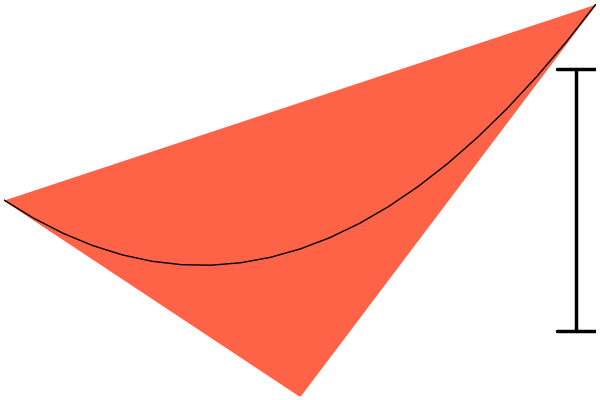

In [15]:
parab_approx([-1. 2], 4.0, [-2, 4])

Interact.Options{:ToggleButtons,Any}(Signal{Any}(4.0, nactions=0),"abstol",4.0,"4.0",Interact.OptionDict(Any["4.0","2.3","0.57","0.15","0.036"],Dict{Any,Any}(Pair{Any,Any}("2.3",2.3),Pair{Any,Any}("0.57",0.57),Pair{Any,Any}("0.15",0.15),Pair{Any,Any}("4.0",4.0),Pair{Any,Any}("0.036",0.036))),Any[],Any[])


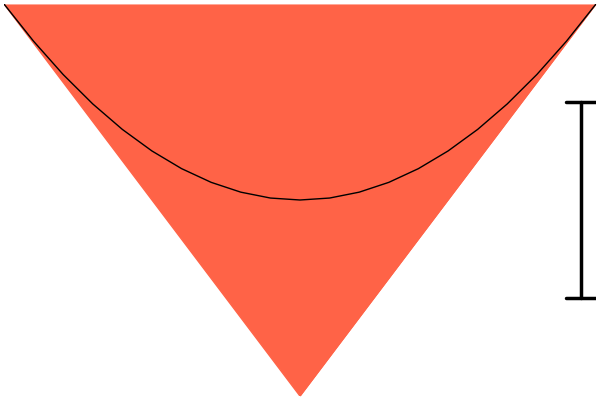

In [16]:
@manipulate for abstol in [4.0, 2.3, 0.57, 0.15, 0.036]
    parab_approx([-2. 2], abstol, [-4, 4])
end

In [17]:
@gif for abstol_exp=0.6:-0.01:-1
    parab_approx([-1. 2], 10.0^abstol_exp, [-2, 4])
end

INFO: Saved animation to /home/tao/projects/18.337/final/tmp.gif


Plots.AnimatedGif("/home/tao/projects/18.337/final/tmp.gif")